## CMPINF 2100 Week 15
### Creating a PIPELINE to manage, PREPROCESSING, Training, Cross-Validation, and Tuning of Models
### Work with a logistic regression example
## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

## Read data
We have been focusing on a single example...

In [2]:
df12 = pd.read_csv("../week_13/week_12_binary_classification.csv")

In [3]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      300 non-null    float64
 1   x2      300 non-null    float64
 2   x3      300 non-null    float64
 3   x4      300 non-null    float64
 4   x5      300 non-null    object 
 5   y       300 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 14.2+ KB


/Applications/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


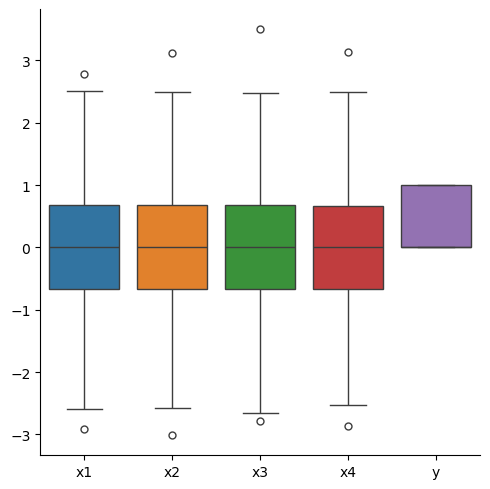

In [4]:
sns.catplot(data=df12, kind="box")
plt.show()

Realistic examples will most likely NOT have all continous inputs with the SAME magnitude and scale!!!

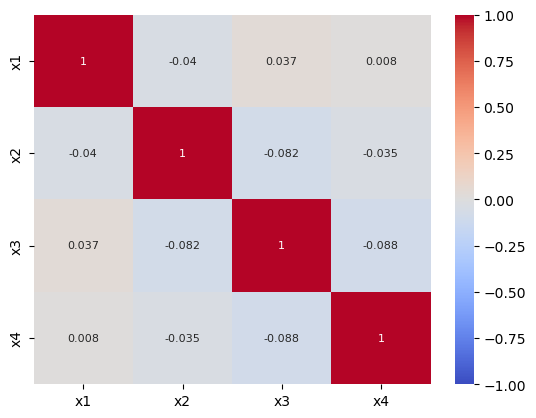

In [15]:
fig, ax = plt.subplots()

sns.heatmap(data=df12.drop(columns=["y"]).corr(numeric_only=True),
            annot=True,
            annot_kws={"fontsize": 8},
            vmin=-1,
            vmax=1,
            center=0,
            cmap="coolwarm",
            ax=ax)

plt.show()

Realistic examples...you may need to deal with highly correlated inputs!!

Lets work on an example that has MANY continuous inputs that are CORRELATED and have DIFFERENT scales and magnitude!!

The SONAR example is a BINARY CLASSIFICATION problem with MANY correlated continuous inputs!

In [16]:
sonar_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'

In [127]:
sonar_df = pd.read_csv( sonar_url, header=None )

In [22]:
sonar_df.shape

(208, 61)

In [23]:
sonar_df.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60],
      dtype='int64')

Lets rename the COLS to show the following patterns!!

In [24]:
sonar_df.columns = ["X%02d" % d for d in sonar_df.columns]

In [25]:
sonar_df.columns

Index(['X00', 'X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29',
       'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39',
       'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49',
       'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59',
       'X60'],
      dtype='object')

In [28]:
sonar_df.dtypes.value_counts()

float64    60
object      1
Name: count, dtype: int64

In [30]:
sonar_df.X60.value_counts(normalize=True)

X60
M    0.533654
R    0.466346
Name: proportion, dtype: float64

Lets change the LAST columns to a name representative of an OUTPUT.

In [31]:
sonar_df.rename(columns={"X60": "response"}, inplace=True)

In [34]:
sonar_df.response.value_counts()

response
M    111
R     97
Name: count, dtype: int64

The INPUTS have different magnitude and scales though all are between 0 and 1.

/Applications/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


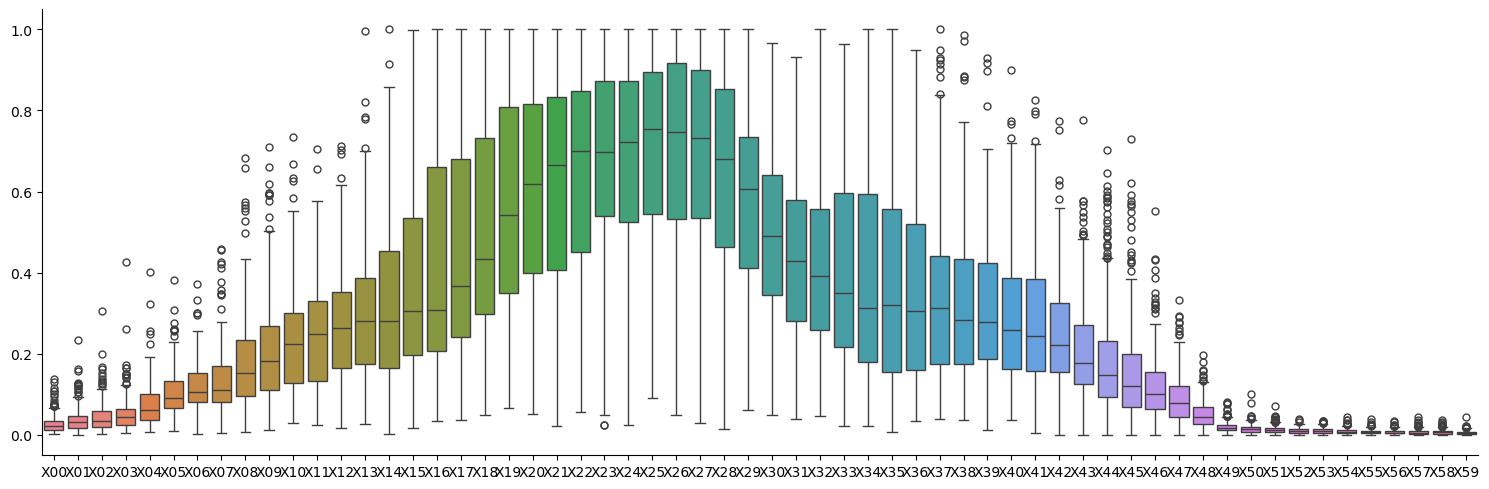

In [35]:
sns.catplot(data=sonar_df,
            kind="box",
            aspect=3)
plt.show()

The INPUTS are HIGHLY correlated!!

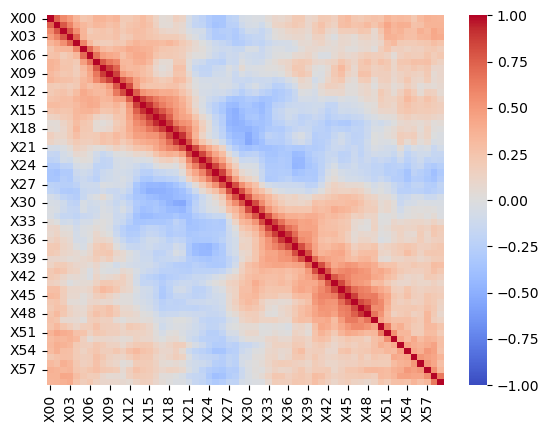

In [36]:
fig, ax = plt.subplots()

sns.heatmap(data=sonar_df.corr(numeric_only=True),
            vmin=-1,
            vmax=1,
            center=0,
            cmap="coolwarm",
            ax=ax)

plt.show()

## Elastic Net Penalty
Why would we want to BLEND or MIX the RIDGE and LASSO penalties?

LASSO does NOT know what to do when FEATURES are highly correlated!!

LASSO may struggle in the presence of highly correlated features, but Ridge can manage highly correlated features because Ridge does NOT truly remove any features!!

Therefore, if TUNING elastic net produces a RIDGE model that tells you that FEATURE CORRELATION is impacting things!!!

However, if we are going to appropriately apply the PENALY we need the INPUTS to have roughly the SAME scale!!!

We therefore cannot just or use LogisticRegressionCV to tune the elastic new penalty!!!

If you ned to PREPROCESS the inputs BEFORE fitting the model!! You **CANNOT** perform the preprocessing BEFORE splitting the data when you are PREPROCESSING with **data dependent transformation**!!!

Data dependent transformations include:
* Standardization (centering and scaling)
* PCA

You CAN apply log-transformations, derive polynomials, apply square root functions, or perform any KNOWN function transformations that DOES NOT DEPEND on the data BEFORE splitting!!!

APPROPRIATELY applying the PREPROCESSING **WITHIN** the folds is very tedious!! It is time consuming and error prone to make sure we execute the PREPROCESSING correctly!! But don't worry there is a dedicated Module to help you!!!!

## Pipeline

Pipeline MANAGES all actions for PREPROCESSING, TRAINING, CV, and TUNING of models!!!

In [37]:
from sklearn.pipeline import Pipeline

The Pipeline module lets us specify the RECIPES, WORKFLOWS, or Pipelines of actions. These actions are called **STEPS**.

However, before creating the actions, lets SEPARATE our INPUT and OUTPUT.

We will focus on models with LINEAR ADDITIVE FEATURES but we WILL NOT use dmatrices to create the features. Instead, we will manually separate them.

In [39]:
xinputs = sonar_df.select_dtypes("number").copy()

In [40]:
youtput = sonar_df.loc[:, ["response"]].copy()

Convert the DataFrames to NumPy arrays.

In [41]:
x_train = xinputs.to_numpy()

In [43]:
y_train = youtput.response.to_numpy().ravel()

In [44]:
x_train.shape

(208, 60)

In [45]:
y_train.shape

(208,)

Our pipeline will consist of 2 steps:
* The first step will standardize.
* The second step will fit an ELASTIC NET model.

We therefore we need to import the appropriate functions.

In [46]:
from sklearn.preprocessing import StandardScaler

In [81]:
from sklearn.linear_model import LogisticRegression

Lets initialize the elastic net model before specifying the steps. Our x_train does **NOT** include the BIAS or INTERCEPT columns!! Therefore we need the typical or conventional style from scikit-learn which estimates the intercept SEPARATELY from the rest of the COEFFICIENTS.

In [55]:
enet_to_fit = LogisticRegression(penalty="elasticnet", solver="saga", max_iter=25001, random_state=202, fit_intercept=True)

Specify the STEPS of the WORKFLOW or PIPELINE.

In [57]:
enet_wflow = Pipeline(steps=[("std_inputs", StandardScaler()), 
                             ("enet", enet_to_fit)])

In [59]:
enet_wflow

Pipeline(steps=[('std_inputs', StandardScaler()),
                ('enet',
                 LogisticRegression(max_iter=25001, penalty='elasticnet',
                                    random_state=202, solver='saga'))])

I did NOT specify the TUNING parameters C and l1_ratio when the elastic new model was initialized!!!!

This is becauser we will ITERATE training and testing the model for many combinations of these two parameters!!! We will use CV to identify the best combo!!

Import the stratified KFold because this a clasisfication problem.

In [60]:
from sklearn.model_selection import StratifiedKFold

In [62]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

In [63]:
kf.get_n_splits()

5

We will SEARCH over a GRID of candidate tuning parameters and the GridSearchCV function manages that search!

In [64]:
from sklearn.model_selection import GridSearchCV

We need to define the GRID of tuning parameters to use with GridSearchCV(). This grid is defined within a dictionary using VERY SPECIFIC set of syntax!!!

In [65]:
enet_grid = {"enet__C": np.exp(np.linspace(-10, 10, num=17)),
            "enet__l1_ratio": np.linspace(0, 1, num=3)}

Initialize the GRID SEARCH.

In [71]:
enet_search = GridSearchCV(enet_wflow, param_grid=enet_grid, cv=kf)

RUN the GRID SEARCH To TUNE the model!!!

In [82]:
enet_search_results = enet_search.fit(x_train, y_train)

The OPTIMAL or TUNED parametes are provided within an attribute.

In [84]:
enet_search_results.best_params_

{'enet__C': 0.2865047968601901, 'enet__l1_ratio': 0.0}

Elastic net converted to RIDGE is the indicator that the INPUT correlation is causing problems!!!

In [85]:
enet_search_results.best_estimator_

Pipeline(steps=[('std_inputs', StandardScaler()),
                ('enet',
                 LogisticRegression(C=0.2865047968601901, l1_ratio=0.0,
                                    max_iter=25001, penalty='elasticnet',
                                    random_state=202, solver='saga'))])

In [89]:
enet_search_results.best_estimator_.named_steps["enet"]

LogisticRegression(C=0.2865047968601901, l1_ratio=0.0, max_iter=25001,
                   penalty='elasticnet', random_state=202, solver='saga')

In [91]:
enet_search_results.best_estimator_.named_steps["enet"].intercept_

array([-0.52605652])

In [125]:
enet_search_results.best_estimator_.named_steps["enet"].coef_

array([[-0.48031266, -0.08525547,  0.41314691, -0.46493591, -0.05667079,
         0.09117113,  0.3401155 ,  0.36800099, -0.38707916, -0.10021863,
        -0.53365167, -0.63398373, -0.04276496,  0.11703359,  0.14690601,
         0.317413  ,  0.21676413, -0.06107757, -0.10858877, -0.23756091,
        -0.17122891, -0.20000584, -0.28335302, -0.32476376,  0.03833571,
         0.11214764, -0.05969174, -0.07426538, -0.21195372, -0.32351555,
         0.79332945, -0.1429114 , -0.2157094 ,  0.11881556,  0.07775472,
         0.50221112,  0.56146731, -0.16499347, -0.26739386,  0.49931635,
         0.0488094 , -0.03572206, -0.16363486, -0.32756059, -0.51518514,
        -0.28454979, -0.09858715, -0.44729453, -0.63107274,  0.63394463,
        -0.32790881, -0.44662418, -0.09950628, -0.33242488,  0.16884579,
        -0.0084909 ,  0.280786  , -0.23319032, -0.21098792, -0.05388896]])

BUT the GRID SEARCH object is a FULL MODEL!!!

Therefore we can DIRECTLY PREDICT WITH IT!

In [94]:
enet_search_results.predict(x_train)[:11]

array(['R', 'R', 'M', 'R', 'R', 'R', 'R', 'M', 'M', 'R', 'R'],
      dtype=object)

In [95]:
enet_search_results.predict_proba(x_train)[:11]

array([[0.27290547, 0.72709453],
       [0.09002394, 0.90997606],
       [0.51565438, 0.48434562],
       [0.22622736, 0.77377264],
       [0.47991705, 0.52008295],
       [0.02038804, 0.97961196],
       [0.09349486, 0.90650514],
       [0.72066156, 0.27933844],
       [0.64450557, 0.35549443],
       [0.3647573 , 0.6352427 ],
       [0.03105078, 0.96894922]])

In [97]:
enet_search_results.classes_

array(['M', 'R'], dtype=object)

In [119]:
enet_search_results.predict_proba(x_train)[:11, enet_search_results.classes_=="M"].ravel()

array([0.27290547, 0.09002394, 0.51565438, 0.22622736, 0.47991705,
       0.02038804, 0.09349486, 0.72066156, 0.64450557, 0.3647573 ,
       0.03105078])

## PCA as a preprocessing step
Elastic Net revealed that the input correlation is causing problems!!

One way to manage correlation is to REMOVE the correlation via PCA!!!

PCA can generate NEW uncorrelated features for us!!!

But...when using CROSS-VALIDATION, you **CANNOT** execute PCA and then SPLIT!!!

You MUST execute PCA within each FOLD!!!

Pipeline will corectly manage the PCA action for you!!

Lets use linear additive features from the Principal Components INSTEAD of the original inputs!!! Therefore, our NEW model will work with UNCORRELATED FEATURES!!!

We can use LASSO rather than worrying about Elastic Net!!

However, we do NOT know how many Principal Components to use!!!!

We learned how the VARIANCE or STANDARD DEVIATION OF THE PCS decreases from the LOWER ORDER PCs to the HIGHER ORDER PCs.\
But...we do NOT know which PC is associated with the BINARY OUTCOME!!! We therefore need to treat the NUMBER OF PCs to use as a TUNING parameter!!

This means you can TUNE PREPROCESSING actions just like TUNE models!!!

First initialize the LASSO model and then define the workflow.

In [130]:
lasso_to_fit = LogisticRegression(penalty="l1", solver="saga", random_state=202, max_iter=25001, fit_intercept=True)

Our new workflow consists of 3 steps. 
* First, STANDARDIZE
* Second, Execute PCA
* Third, FIT LASSO model

In [131]:
from sklearn.decomposition import PCA

In [132]:
pc_lasso_wflow = Pipeline(steps=[("std_inputs", StandardScaler()),
                                ("pca", PCA()),
                                ("lasso", lasso_to_fit)])

In [133]:
pc_lasso_wflow

Pipeline(steps=[('std_inputs', StandardScaler()), ('pca', PCA()),
                ('lasso',
                 LogisticRegression(max_iter=25001, penalty='l1',
                                    random_state=202, solver='saga'))])

We now have TUNING parameters coming from 2 different steps, the parameter names reflect the STEP they are associated within the tuning grid!!!

In [134]:
pc_lasso_grid = {"pca__n_components": [3,5,7,9,11,13,15,17],
            "lasso__C": np.exp(np.linspace(-10, 10, num=17))}

In [136]:
pc_lasso_search = GridSearchCV(pc_lasso_wflow, param_grid=pc_lasso_grid, cv=kf)

In [137]:
pc_lasso_results = pc_lasso_search.fit(x_train, y_train)

In [139]:
pc_lasso_results

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             estimator=Pipeline(steps=[('std_inputs', StandardScaler()),
                                       ('pca', PCA()),
                                       ('lasso',
                                        LogisticRegression(max_iter=25001,
                                                           penalty='l1',
                                                           random_state=202,
                                                           solver='saga'))]),
             param_grid={'lasso__C': array([4.53999298e-05, 1.58461325e-04, 5.53084370e-04, 1.93045414e-03,
       6.73794700e-03, 2.35177459e-02, 8.20849986e-02, 2.86504797e-01,
       1.00000000e+00, 3.49034296e+00, 1.21824940e+01, 4.25210820e+01,
       1.48413159e+02, 5.18012825e+02, 1.80804241e+03, 6.31068811e+03,
       2.20264658e+04]),
                         'pca__n_components': [3, 5, 7, 9, 11, 13, 15, 17]})

In [140]:
pc_lasso_results.best_params_

{'lasso__C': 1.0, 'pca__n_components': 17}

In [141]:
pc_lasso_results.best_score_

0.7932636469221835

In [142]:
pc_lasso_results.best_estimator_.named_steps["lasso"].intercept_

array([-0.50375423])

In [144]:
pc_lasso_results.best_estimator_.named_steps["lasso"].coef_

array([[-0.27609451, -0.31022605, -1.00420617,  0.02689006,  0.08385315,
        -0.08646955, -0.46234318,  0.        ,  0.86012438, -0.57263157,
        -0.03356777,  0.01253469,  0.        , -0.51575382,  0.08714524,
        -0.04273807, -0.52078244]])

## Interact Principal Components
An interaction is a MULTIPLICATION or PRODUCT. What would happen if we INTERACTED all PAIRS of the original inputs?

(x1 + x2 + x3 + x4 + x5 + x6)**2

However, there is a function that can generate all MAIN EFFECTS and ALL PAIR WISE PRODUCTS (interactions) for us!!

In [145]:
from sklearn.preprocessing import PolynomialFeatures

Has an argument, `degree`, which specifies the DEGREE of the POLYNOMIAL and it has an argument, `interaction_only`, which specifies if we ARE ONLY creating the MAIN EFFECTS and INTERACTIONS **NOT** raising inputs to polynomial powers!

In [148]:
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(x_train).shape

(208, 1830)

We therefore CANNOT interact ALL pairs of the original inputs!!

But..we could derive a smaller number of features such as PCA...how many could we interact???

In [151]:
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(x_train[:, :19]).shape

(208, 190)

We can create ALL PAIR WISE PRODUCTS if we have LESS THAN 19 features!!!!

So lets use PCA to generate the uncorrelated FEATURES and then DERIVE the pair wise products from the Principal COMPONENTS!!!!

In [152]:
make_pairs = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

Define the Pipeline for the PC, with interaction and LASSO model!!!

In [153]:
pc_interact_lasso_wflow = Pipeline(steps=[("std_inputs", StandardScaler()),
                                         ("pca", PCA()),
                                         ("make_pairs", make_pairs),
                                         ("lasso", lasso_to_fit)])

In [154]:
pc_interact_lasso_wflow

Pipeline(steps=[('std_inputs', StandardScaler()), ('pca', PCA()),
                ('make_pairs',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('lasso',
                 LogisticRegression(max_iter=25001, penalty='l1',
                                    random_state=202, solver='saga'))])

Lets use the SAME search grid from before.

In [155]:
pc_interact_lasso_search = GridSearchCV(pc_interact_lasso_wflow, param_grid=pc_lasso_grid, cv=kf)

RUN THE GRID SEARCH!!!

In [156]:
pc_interact_lasso_search_grid = pc_interact_lasso_search.fit(x_train, y_train)

In [157]:
pc_interact_lasso_search_grid.best_params_

{'lasso__C': 3.4903429574618414, 'pca__n_components': 5}

In [158]:
pc_interact_lasso_search_grid.best_score_

0.8363530778164924

In [160]:
pc_lasso_results.best_score_

0.7932636469221835

In [161]:
enet_search_results.best_score_

0.7981416957026713

In [162]:
pc_interact_lasso_search_grid.best_estimator_.named_steps["lasso"].coef_

array([[-0.36126761, -0.2497483 , -1.3246495 , -0.31678781,  0.19370547,
         0.00581584,  0.06525403,  0.00301119, -0.26115296,  0.2454644 ,
         0.18793078, -0.12381615, -0.06896489, -0.28195106,  0.12552979]])

We improved the ACCURACY of a Logistic Regession Model by Executing rather complex PREPROCESSING ACTIONS!!!